<a href="https://colab.research.google.com/github/ericmcg13/CCT-CA1/blob/main/CA1_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'Dash' is a required install for use of the plotly graphics and sliders.

'ipyleaflet' is used for the geo mapping and Choropleth layer



# New section

In [ ]:
!pip install dash
!pip install ipyleaflet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

# Set the plot to retina quality
%config InlineBackend.figure_format = "retina"

# Set the 'talk' library in SNS (Changes the size and labels to graphs to make them bigger)
sns.set_context('talk')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_mode_interactivity = 'all'

###

# Below is only require for COLAB

###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
migration_df = pd.read_csv("/content/drive/MyDrive/Migration.csv")
migration_df.head(5)

,Statistic,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,All ages,Both sexes,Net migration,Thousand,-23.0
1,Estimated Migration (Persons in April),1987,All ages,Both sexes,Emigrants: All destinations,Thousand,40.2
2,Estimated Migration (Persons in April),1987,All ages,Both sexes,Immigrants: All origins,Thousand,17.2
3,Estimated Migration (Persons in April),1987,All ages,Male,Net migration,Thousand,NaN
4,Estimated Migration (Persons in April),1987,All ages,Male,Emigrants: All destinations,Thousand,NaN


In [5]:
migration_df.shape
migration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Statistic               1890 non-null   object 
 1   Year                    1890 non-null   int64  
 2   Age Group               1890 non-null   object 
 3   Sex                     1890 non-null   object 
 4   Inward or Outward Flow  1890 non-null   object 
 5   UNIT                    1890 non-null   object 
 6   VALUE                   1575 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 103.5+ KB


In [6]:
# Remove NaN values
migration_df.dropna(inplace=True)

In [7]:
migration_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1575 entries, 0 to 1889
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Statistic               1575 non-null   object 
 1   Year                    1575 non-null   int64  
 2   Age Group               1575 non-null   object 
 3   Sex                     1575 non-null   object 
 4   Inward or Outward Flow  1575 non-null   object 
 5   UNIT                    1575 non-null   object 
 6   VALUE                   1575 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 98.4+ KB


In [8]:
# Group the totals by age cohort
migration_sum_df = migration_df.groupby('Age Group').sum()

# Remove the TOTAL column from the graph as it distorts the figures
# migration_sum_df.drop("All ages", axis=0, inplace=True)
migration_sum_df

,Year,VALUE
Age Group,,
0 - 14 years,541530,885.9
15 - 24 years,541530,3003.2
25 - 44 years,541530,3840.5
45 - 64 years,541530,588.3
65 years and over,541530,213.2
All ages,451800,7392.7


In [9]:
# Filter the df by NET MIGRATION for ALL AGES and BOTH SEXES to get the totals
net_migration = migration_df[(migration_df['Inward or Outward Flow'] == 'Net migration') & 
                             (migration_df['Age Group'] == 'All ages') &
                             (migration_df['Sex'] == 'Both sexes')]
net_migration.head()

,Statistic,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,All ages,Both sexes,Net migration,Thousand,-23.0
54,Estimated Migration (Persons in April),1988,All ages,Both sexes,Net migration,Thousand,-41.9
108,Estimated Migration (Persons in April),1989,All ages,Both sexes,Net migration,Thousand,-43.9
162,Estimated Migration (Persons in April),1990,All ages,Both sexes,Net migration,Thousand,-22.9
216,Estimated Migration (Persons in April),1991,All ages,Both sexes,Net migration,Thousand,-2.0


In [11]:
# Show the inital graph to get a sense of the pattern (if any)
fig = px.line(net_migration, x='Year', y='VALUE', color='Sex')
fig.show()

In [13]:
# Bring in the Birth/Death dataframe
bdm_df = pd.read_csv('/content/drive/MyDrive/BDM_Ireland1960_2021.csv')
bdm_df.head()

,Quarter,State,Marriages Registered (Number),"Marriage Rate Registered per 1,000 Estimated Population (Number)",Deaths Registered (Number),"Death Rate Registered per 1,000 Estimated Population (Number)","Deaths of Infants under 1 Year Registered per 1,000 Births (Number)",Births Registered (Number),"Birth Rate Registered per 1,000 Estimated Population (Number)"
0,1960Q1,Ireland,2987,4.2,9399,13.3,34.7,14614,20.6
1,1960Q2,Ireland,3501,4.9,7882,11.1,26.8,16494,23.1
2,1960Q3,Ireland,5900,8.3,6950,9.8,26.3,15612,22.2
3,1960Q4,Ireland,3106,4.4,8427,11.7,29.7,14010,19.8
4,1961Q1,Ireland,2179,3.1,11883,17.1,34.9,14692,20.8


In [14]:
bdm_df.info()
bdm_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 9 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Quarter                                                              245 non-null    object 
 1   State                                                                245 non-null    object 
 2   Marriages Registered (Number)                                        245 non-null    int64  
 3   Marriage Rate Registered per 1,000 Estimated Population (Number)     245 non-null    float64
 4   Deaths Registered (Number)                                           245 non-null    int64  
 5   Death Rate Registered per 1,000 Estimated Population (Number)        245 non-null    float64
 6   Deaths of Infants under 1 Year Registered per 1,000 Births (Number)  245 non-null    float64
 7   Births Re

(245, 9)

In [15]:
# Computer the net delta population growth (birth - death)
bdm_df['Growth'] = bdm_df['Births Registered (Number)'] - bdm_df['Deaths Registered (Number)']

# Use Lambda to iterate over the values in each cell to remove the QUARTER time values.
bdm_df['Quarter'] = bdm_df['Quarter'].map(lambda x: str(x)[:-2])

In [16]:
bdm_df.head()

,Quarter,State,Marriages Registered (Number),"Marriage Rate Registered per 1,000 Estimated Population (Number)",Deaths Registered (Number),"Death Rate Registered per 1,000 Estimated Population (Number)","Deaths of Infants under 1 Year Registered per 1,000 Births (Number)",Births Registered (Number),"Birth Rate Registered per 1,000 Estimated Population (Number)",Growth
0,1960,Ireland,2987,4.2,9399,13.3,34.7,14614,20.6,5215
1,1960,Ireland,3501,4.9,7882,11.1,26.8,16494,23.1,8612
2,1960,Ireland,5900,8.3,6950,9.8,26.3,15612,22.2,8662
3,1960,Ireland,3106,4.4,8427,11.7,29.7,14010,19.8,5583
4,1961,Ireland,2179,3.1,11883,17.1,34.9,14692,20.8,2809


In [17]:
# We only need the time and growth delta for graphing
growth = bdm_df[['Quarter', 'Growth']].copy()
growth = growth.groupby(['Quarter'], as_index=False)['Growth'].sum()

# Quarter has been removed, only YEAR remains
growth.columns = ['Year', 'Growth Delta']
growth.head()

,Year,Growth Delta
0,1960,28072
1,1961,25278
2,1962,27968
3,1963,29408
4,1964,31535


In [18]:
# drop years less than 1987 for comparison with Growth
compare_growth = growth[growth['Year'] > '1986']

fig1 = px.line(compare_growth, x='Year', y='Growth Delta')
fig1.show()

In [19]:
# We only need the Year and migration totals for graphing
migration_df_simplified = net_migration[['Year', 'VALUE']].copy()

# Convert STRING year in compare_growth to INT so that a JOIN can be performed
compare_growth['Year'] = pd.to_numeric(compare_growth['Year'])

# Join Columns
merge_df = pd.merge(compare_growth, migration_df_simplified, how='outer', on='Year')

# Fix VALUE column name and add
merge_df.rename({'VALUE':'Migration Delta'}, axis=1, inplace=True)
merge_df['Migration Delta'] = merge_df['Migration Delta'].apply(lambda x: int(x * 1000))
merge_df.head()

,Year,Growth Delta,Migration Delta
0,1987,27645,-23000
1,1988,22725,-41900
2,1989,20556,-43900
3,1990,21136,-22900
4,1991,21192,-2000


In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# Add trace - Growth
fig2.add_trace(
    go.Scatter(x=merge_df['Year'], y=merge_df['Growth Delta'], name="Growth"),
    secondary_y=False,
)

# Add trace - Migration
fig2.add_trace(
    go.Scatter(x=merge_df['Year'], y=merge_df['Migration Delta'], name="Migration"),
    secondary_y=False,
)

# Add figure title
fig2.update_layout(
    title_text="Pop Growth and Migration"
)

# Set x-axis title
fig2.update_xaxes(title_text="Year")

# Set y-axes titles
fig2.update_yaxes(title_text="Population", secondary_y=False)
fig2.show()

In [22]:
# Import the employment data
employment_df = pd.read_csv('/content/drive/MyDrive/Vacancies.csv')
employment_df.head()

,Statistic,Quarter,Economic Sector NACE Rev 2,Private or Public Sector,UNIT,VALUE
0,Employment,2008Q1,All NACE economic sectors,Private sector,Number,1350200.0
1,Employment,2008Q1,All NACE economic sectors,Public sector,Number,417000.0
2,Employment,2008Q1,All NACE economic sectors,All sectors,Number,1767200.0
3,Employment,2008Q1,Construction (F),Private sector,Number,NaN
4,Employment,2008Q1,Construction (F),Public sector,Number,NaN


In [23]:
employment_df.info()
employment_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Statistic                   6804 non-null   object 
 1   Quarter                     6804 non-null   object 
 2   Economic Sector NACE Rev 2  6804 non-null   object 
 3   Private or Public Sector    6804 non-null   object 
 4   UNIT                        6804 non-null   object 
 5   VALUE                       2560 non-null   float64
dtypes: float64(1), object(5)
memory usage: 319.1+ KB


(6804, 6)

In [24]:
employment_df['Statistic'].unique()

array(['Employment', 'Number of Job Vacancies', 'Job Vacancies'],
      dtype=object)

In [26]:
# We need the total number of vacancies for all sectors in all industries to get the totals
employment_df = employment_df[(employment_df['Statistic'] == 'Number of Job Vacancies') &
                             (employment_df['Private or Public Sector'] == 'All sectors') &
                             (employment_df['Economic Sector NACE Rev 2'] == 'All NACE economic sectors')] 

employment_df.head()

,Statistic,Quarter,Economic Sector NACE Rev 2,Private or Public Sector,UNIT,VALUE
2270,Number of Job Vacancies,2008Q1,All NACE economic sectors,All sectors,Number,17900.0
2312,Number of Job Vacancies,2008Q2,All NACE economic sectors,All sectors,Number,15500.0
2354,Number of Job Vacancies,2008Q3,All NACE economic sectors,All sectors,Number,12500.0
2396,Number of Job Vacancies,2008Q4,All NACE economic sectors,All sectors,Number,7700.0
2438,Number of Job Vacancies,2009Q1,All NACE economic sectors,All sectors,Number,7000.0


In [27]:
# Use Lambda to iterate over the values in each cell and remove QUARTER time data
employment_df['Quarter'] = employment_df['Quarter'].map(lambda x: str(x)[:-2])

# We only need the year and total vacancies for graphing
vacancies_df = employment_df[['Quarter', 'VALUE']].copy()
vacancies_df = vacancies_df.groupby(['Quarter'], as_index=False)['VALUE'].sum()

# Quarter has been removed, rename to year time frame
vacancies_df.columns = ['Year', 'Open Vacancies']
vacancies_df.head()

,Year,Open Vacancies
0,2008,53600.0
1,2009,23100.0
2,2010,29300.0
3,2011,32100.0
4,2012,35500.0


In [28]:
# Add the job vacancies data to the already created graph with the growth and pop data
fig2.add_trace(
    go.Scatter(x=vacancies_df['Year'], y=vacancies_df['Open Vacancies'], name="Open Vacancies"),
    secondary_y=False,
)
fig2.show()

In [29]:
# Prepare the merge df to add the job vacancies data (only 2008 onwards is available in vacancies)
merge_df = merge_df[merge_df['Year'] >= 2008]

# Cast the Year columns as a Int for merge
vacancies_df['Year'] = pd.to_numeric(vacancies_df['Year'])

# Add the vacancies df with merge
merge_df = pd.merge(merge_df, vacancies_df, how='outer', on='Year')
merge_df

,Year,Growth Delta,Migration Delta,Open Vacancies
0,2008,47509,64300,53600.0
1,2009,46030,1600,23100.0
2,2010,47411,-27500,29300.0
3,2011,45655,-27400,32100.0
4,2012,43377,-25700,35500.0
5,2013,38912,-18700,42100.0
6,2014,38337,-8500,46100.0
7,2015,35957,5900,62100.0
8,2016,33507,16200,66600.0
9,2017,31569,19800,73500.0


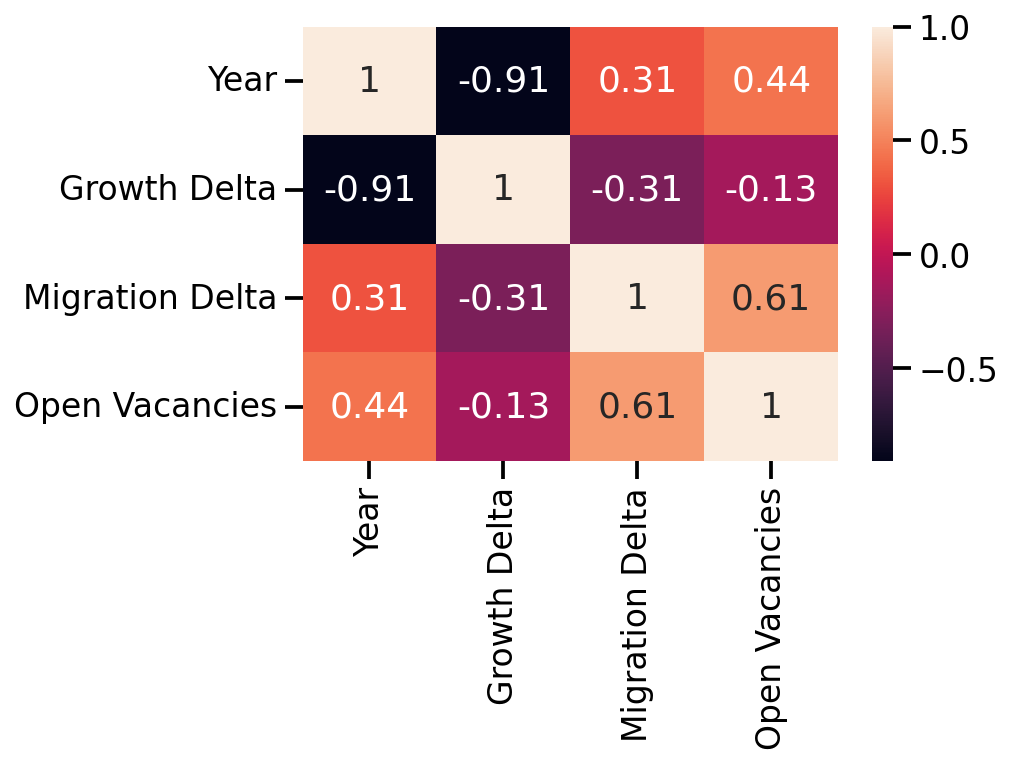

In [30]:
# Appears to be a corr. between migration and job vacancies - is this true?
corrMatrix = merge_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Heatmap shows that Migration numbers a moderately correlated to Open Job Vacancies
# and that Population growth as a birth/death ratio has been on the decline since 2008
# ML to show the correlation